In [2]:
%load_ext rpy2.ipython

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import TiffFile

In [4]:
tif_out_path = 'data/VIIRS/generated/'

## Average Stable Lights

In [4]:
%%time
tif_paths = [
    'data/VIIRS/F101992.v4/F101992.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101993.v4/F101993.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101994.v4/F101994.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121994.v4/F121994.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121995.v4/F121995.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121996.v4/F121996.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F182013.v4/F182013.v4c_web.stable_lights.avg_vis.tif'
]
t_years = len(tif_paths)
n = 16801
m = 43201

images = np.zeros((len(tif_paths),n,m))
                  
for i, p in enumerate(tif_paths):
    with TiffFile(p) as tif:
        images[i] = tif.asarray()

CPU times: user 12.4 s, sys: 32.9 s, total: 45.4 s
Wall time: 1min 1s


### Extracting Subimages (Convolutional Style)

In [5]:
def convolve_coordinates(image, step_size = (150,150), sub_image_shape = (300,300)):
    passes = [int(image.shape[i]/step_size[i]-sub_image_shape[i]/step_size[i]+1) for i in range(2)]
    sub_image_coordinates = np.zeros((*passes,2,2))
    for i in range(passes[0]):
        step_i = i*step_size[0]
        for j in range(passes[1]):
            step_j = j*step_size[1]
            sub_image_coordinates[i,j] = [
                [step_i,step_i+sub_image_shape[0]],
                [step_j,step_j+sub_image_shape[1]]
            ]
            
    return sub_image_coordinates.reshape(passes[0]*passes[1],2,2)

In [6]:
%%time
sub_img_pxl = np.zeros((t_years, 31857, 2, 2))

for t, img in enumerate(images):
    sub_img_pxl[t] = convolve_coordinates(img)
    
sub_img_pxl.shape

CPU times: user 642 ms, sys: 14.9 ms, total: 657 ms
Wall time: 692 ms


Function using coordinates to retrieve information (faster)

In [7]:
def retrieve_sub_img(image,img_pxl):
    return image[img_pxl[0][0]:img_pxl[0][1],
                 img_pxl[1][0]:img_pxl[1][1]]

In [ ]:
def get_pxl(df):
    return [
        [df['pxll'][0],df['pxlb'][0]],
        [df['pxll'][0],df['pxlr'][0]]
    ]

Construct dataframe

In [ ]:
%%time
X_df = pd.DataFrame(columns=['year','i','f','t','mean_luminosity','pxlt','pxlb','pxll','pxlr'])

for t in range(t_years):
    for i, img_pxl in enumerate(sub_img_pxl[t]):
        X_df = X_df.append(pd.DataFrame([[
            tif_paths[t][-49:-45],
            str(i) + ' ' + str(t),
            str(i),
            t,
            np.mean(retrieve_sub_img(images[t],img_pxl)),
            img_pxl[0,0],
            img_pxl[0,1],
            img_pxl[1,0],
            img_pxl[1,1],
        ]],
            columns=['year','i','f','t','mean_luminosity','pxlt','pxlb','pxll','pxlr'],
            index=[tif_paths[t][-52:-45]+' '+str(i)]
        ))
        
X_df.to_csv('data/features.csv',index=False)
X_df = X_df.set_index(['i'])
X_df.head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [ ]:
X_df = pd.read_csv('data/features.csv', index_col='i')
X_df.head()

Only very few of the subimages contain a lot of lighting. This is good since we only want to extract areas with lots of luminosity information.

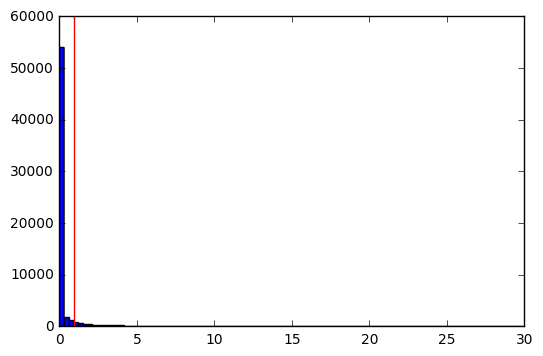

In [29]:
plt.hist(X_df['mean_luminosity'], bins=100)
plt.axvline(np.percentile(X_df['mean_luminosity'],90),color="red")
plt.show()

Lets find the brightest spots on earth 
* This really needs coordinates

In [28]:
X_df = X_df.sort('mean_luminosity',ascending=False)
X_df.head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,f,t,mean_luminosity,pxltl,pxlbl,pxltr,pxlbr
i,,,,,,,
213 5,213,5.0,20.989422,5250.0,5550.0,25200.0,25500.0
285 5,285,5.0,18.375056,5250.0,5550.0,36000.0,36300.0
284 5,284,5.0,15.425867,5250.0,5550.0,35850.0,36150.0
249 5,249,5.0,14.591756,5250.0,5550.0,30600.0,30900.0
410 5,410,5.0,14.002633,5400.0,5700.0,11700.0,12000.0


In [29]:
X_df.groupby('f').var().sort('mean_luminosity',ascending=False)['mean_luminosity'].head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


f
285    31.823715
284    23.539272
213    21.790467
212     9.923177
249     9.349643
Name: mean_luminosity, dtype: float64

In [49]:
location_change = X_df[X_df['f'] == 213].sort('t')
location_change

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,f,t,mean_luminosity,pxltl,pxlbl,pxltr,pxlbr
i,,,,,,,
213 0,213,0.0,8.647522,5250.0,5550.0,25200.0,25500.0
213 1,213,1.0,9.101011,5250.0,5550.0,25200.0,25500.0
213 2,213,2.0,9.403800,5250.0,5550.0,25200.0,25500.0
213 3,213,3.0,10.578000,5250.0,5550.0,25200.0,25500.0
213 4,213,4.0,11.465000,5250.0,5550.0,25200.0,25500.0
213 5,213,5.0,20.989422,5250.0,5550.0,25200.0,25500.0


In [50]:
location_change['mean_luminosity'].diff()[1:]

i
213 1    0.453489
213 2    0.302789
213 3    1.174200
213 4    0.887000
213 5    9.524422
Name: mean_luminosity, dtype: float64

### Calculate Luminosity Change over time period
$$
\mathbb{L}_{i+1} - \mathbb{L}_{i} = \mathbb{L}_{\delta} \text{ luminosity delta}
$$

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


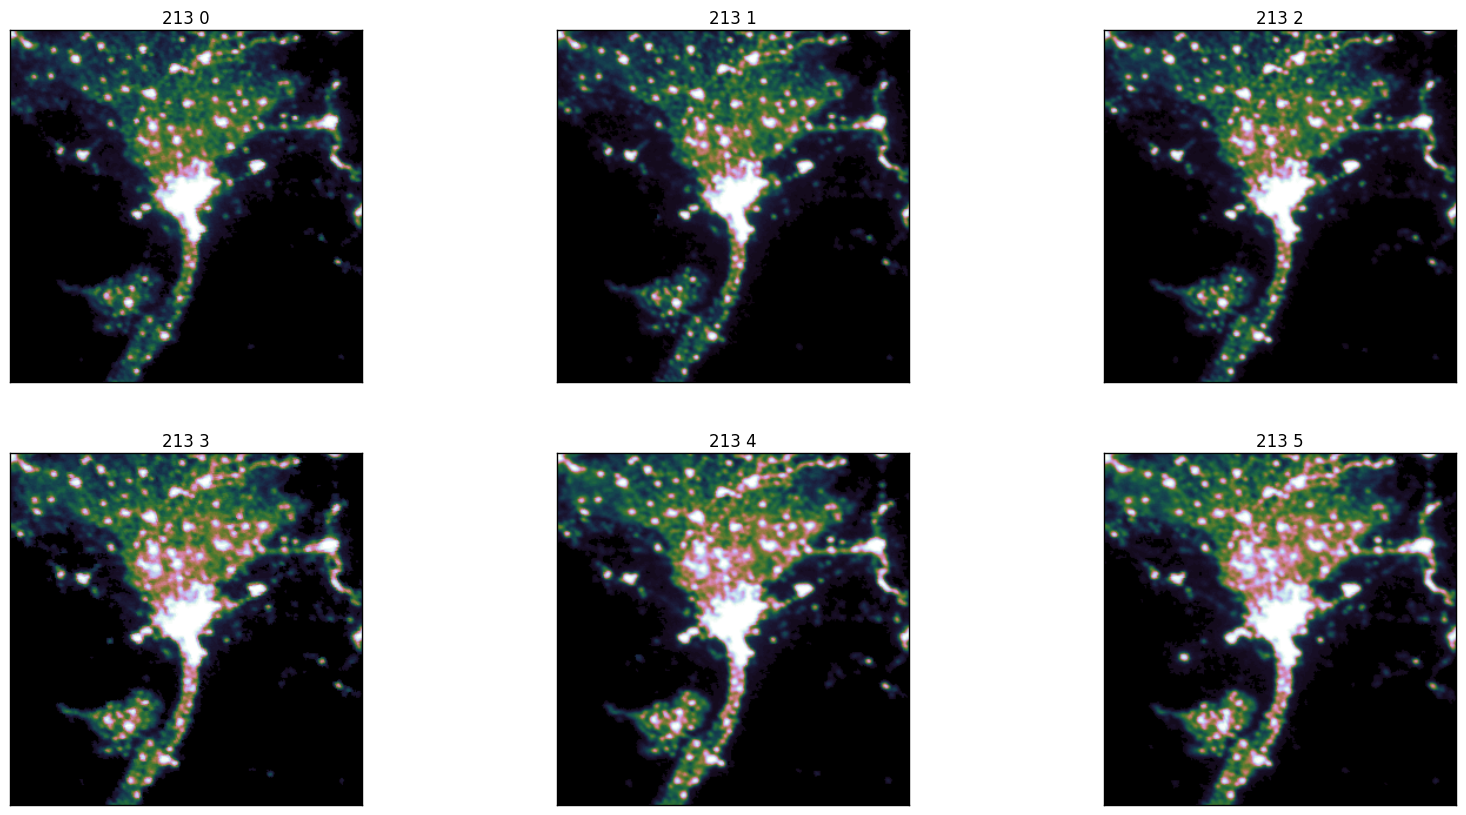

In [99]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
for i, axi in enumerate(ax.flat):
    sub_img = retrieve_sub_img(images[i],
                     [
                         [location_change['pxll'][i],location_change['pxlb'][i]],
                         [location_change['pxll'][i],location_change['pxlr'][i]]
                     ])
    axi.imshow(sub_img,cmap='cubehelix',)
    axi.set(xticks=[], yticks=[],title=location_change.index[i])

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


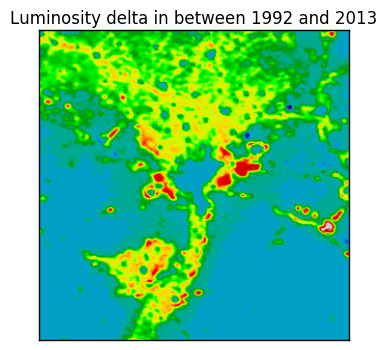

In [107]:
img_pxl = get_pxl(location_change)

plt.imshow(retrieve_sub_img(images[-1],img_pxl) - retrieve_sub_img(images[0],img_pxl), cmap='spectral')
plt.xticks([])
plt.yticks([])
plt.title('Luminosity delta in between 1992 and 2013')
plt.show()

Barcelona Luminosity Change between 1992 and 2013

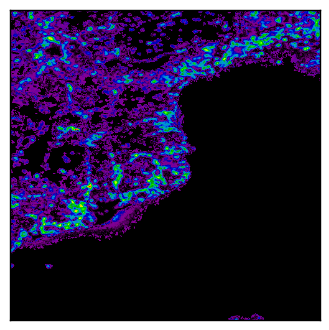

In [109]:
plt.imshow(abs(images[0][3700:4200,21700:22200] - images[-1][3700:4200,21700:22200]), cmap='spectral')
plt.xticks([])
plt.yticks([])
plt.show()

Generalise for features (general measure of change)

## Coordinates

From the [data description](https://www.ngdc.noaa.gov/eog/gcv4_readme.txt):
```
The products are 30 arc second grids, spanning -180 to 180 degrees longitude and -65 to 75 degrees latitude.
```

Let's find the equator first

In [145]:
equator_row = np.floor(75/(65+75) * 16801)
width = 2000
equator_row

9000.0

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


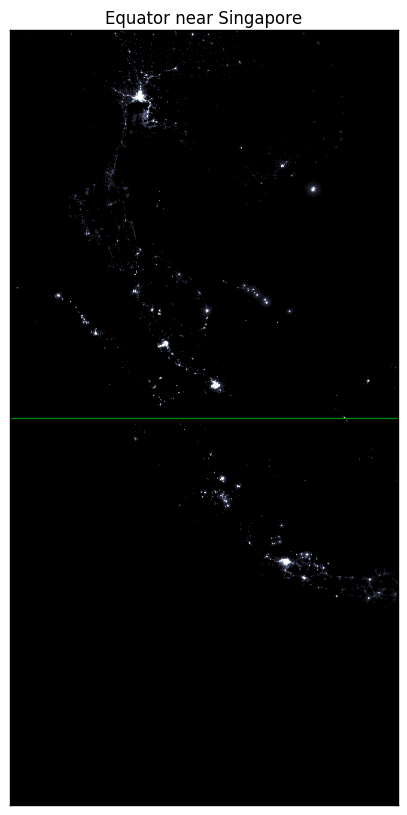

In [150]:
plt.figure(figsize=(20,10))
d = 33000
plt.imshow(images[0,equator_row-width:equator_row+width,d:(d+2000)], cmap='bone')
plt.axhline(y=width,color='green')
plt.xticks([])
plt.yticks([])
plt.title('Equator near Singapore')
plt.show()

Coordinates of Singapore in degrees and decimal minutes

Latitude: 1°17.3802′ N	
Longitude: 103°51.0042′ E

In [153]:
images[0].shape

(16801, 43201)

In [183]:
singapore_location = (16801 / ( 75 + 65 ) * (75 - 1), 43201 / 360 * (180 + 103.5))
singapore_location

(8880.528571428571, 34020.7875)

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


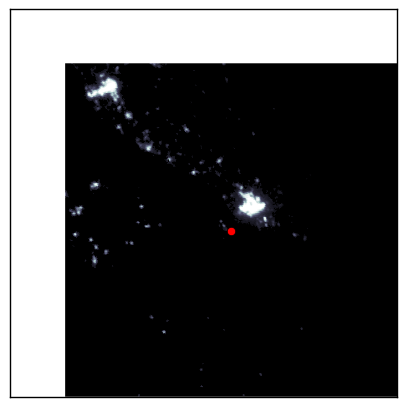

In [201]:
plt.figure(figsize=(10,5))
d=300
plt.imshow(images[0,
                  (singapore_location[0]-d):(singapore_location[0]+d),
                  (singapore_location[1]-d):(singapore_location[1]+d)], 
           cmap='bone')
plt.plot(d,d,'ro')
plt.xticks([])
plt.yticks([])
plt.show()

That's not too bad. At least we're close.

Fukushima Coordinates: 37°46′N 140°28′E

In [202]:
fukushima_location = (16801 / ( 75 + 65 ) * (75 - 37.5), 43201 / 360 * (180 + 140))
fukushima_location

(4500.267857142857, 38400.88888888889)

In [1]:
plt.figure(figsize=(10,5))
d=300
plt.imshow(images[-1,
                  (fukushima_location[0]-d):(fukushima_location[0]+d),
                  (fukushima_location[1]-d):(fukushima_location[1]+d)] 
           - images[-2,
                  (fukushima_location[0]-d):(fukushima_location[0]+d),
                  (fukushima_location[1]-d):(fukushima_location[1]+d)], 
           cmap='magma')
# plt.plot(d,d,'ro')
plt.xticks([])
plt.yticks([])
plt.show()

NameError: name 'plt' is not defined

In [6]:
images[0].shape

(16801, 43201)